# Analysis of the Shelterin Knockdown Data #

This workbook describes the analysis performed on the STORM data of Hela cells with various shelterin knockdowns.

We started looking at the day-to-day variation in the mean and median radius of gyration ($R_g$) values because we found that some of the datasets were more strongly influencing the shape of the pooled distributions than others. My first attempts at plotting these variations was to plot the mean (or median) radius of gyration as a function of the day the experiment was run. The two time-series curves for the control (pSuper) and the knockdown were compared like this.

This seemed to incur a lot of opposition from my group, partly because they saw large changes in the absolute size as troublesome. Seamus suggested instead plotting their differences; this makes sense because there's a strong correlation in relative differences when plotted day-to-day, even if the absolute values change by a lot.

Now, I will try plotting the differences between control and knockdowns to see if this is more informative for assessing the dependence of telomere size on any particular Shelterin component.

## Setup the environment ##

In [1]:
%pylab

# Enable plotting inside this document
%matplotlib inline

import scipy.io as sio
import day2day as d2d
from sigTestHelpers import bootstrapDiff

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
pathToDists = '../Experiment_6_Pool_TRF1_TRF2/'

# Read the Matlab data into the Python namespace
mlData = sio.loadmat(''.join((pathToDists, 'matlab.mat')), variable_names = 'data')

# List of experiment names to read
# (Note that we're not including the pooled data anymore)
expName = {'pSuper' : ['08-09-2014 pSuper',
                       '09-09-2014 pSuper',
                       '21-10-2014 pSuper',
                       '05-11-2014 pSuper',
                       '17-11-2014 pSuper'],
           'TRF1' :   ['08-09-2014 TRF1',
                       '09-09-2014 TRF1',
                       '21-10-2014 TRF1',
                       '05-11-2014 TRF1',
                       '17-11-2014 TRF1'],
           'TRF2' :   ['08-09-2014 TRF2',
                       '09-09-2014 TRF2',
                       '21-10-2014 TRF2',
                       '05-11-2014 TRF2',
                       '17-11-2014 TRF2'],
           'TRF1/2' : ['08-09-2014 TRF1 TRF2',
                       '09-09-2014 TRF1 TRF2',
                       '21-10-2014 TRF1 TRF2',
                       '05-11-2014 TRF1 TRF2',
                       '17-11-2014 TRF1 TRF2']}

stats = {'Hela L' : {'Mean' : {'Diffs' : {}}, 'Median' : {'Diffs' : {}}, 'Std. Err.' : {'Diffs' : {}}},
         'Hela S' : {'Mean' : {'Diffs' : {}}, 'Median' : {'Diffs' : {}}, 'Std. Err.' : {'Diffs' : {}}}}

# Remove pSuper from experiment names to make plot xtick labels
ticklabels = []
for label in expName['pSuper']:
    ticklabels.append(label[:-7])
ticklabels = sorted(ticklabels)


## Read the distributions into memory ##

In [3]:
# Define the dictionary for holding the distribution data
dists = {'Hela L' : {name: {} for name in expName.keys()},
         'Hela S' : {name: {} for name in expName.keys()}}

# Assign the distribution for each data to a leaf in the tree of distributions above
for name in expName.keys():
    dists['Hela L'][name], _ = d2d.findStats(mlData, expName[name], cellType = 'L', statistic = 'identity')
    dists['Hela S'][name], _ = d2d.findStats(mlData, expName[name], cellType = 'S', statistic = 'identity')

## Compute the summary statistics ##

In [4]:
# Calculate all means, medians, and standard errors of the means
for name in expName.keys():
    stats['Hela L']['Mean'][name],   stats['Hela L']['Std. Err.'][name]   = d2d.findStats(mlData, expName[name], cellType = 'L', statistic = 'mean')
    stats['Hela L']['Median'][name], _                                    = d2d.findStats(mlData, expName[name], cellType = 'L', statistic = 'median')
    
    stats['Hela S']['Mean'][name],   stats['Hela S']['Std. Err.'][name]   = d2d.findStats(mlData, expName[name], cellType = 'S', statistic = 'mean')
    stats['Hela S']['Median'][name], _                                    = d2d.findStats(mlData, expName[name], cellType = 'S', statistic = 'median')

### Find differences between knockdowns and control ###

Now that the means and medians for each experiment have been calculated, we'll compute the difference between each knockdown experiment and the control (labeled pSuper).

In [5]:
# Filter out pSuper from names of keys
listOfKDs = list(filter(lambda x: (x != 'pSuper') and (x != 'Diffs'), stats['Hela L']['Mean'].keys()))

for knockdown in listOfKDs:
    diffMeanL   = -d2d.sortStats(stats['Hela L']['Mean']['pSuper'])   + d2d.sortStats(stats['Hela L']['Mean'][knockdown])
    diffMedianL = -d2d.sortStats(stats['Hela L']['Median']['pSuper']) + d2d.sortStats(stats['Hela L']['Median'][knockdown])
    diffMeanS   = -d2d.sortStats(stats['Hela S']['Mean']['pSuper'])   + d2d.sortStats(stats['Hela S']['Mean'][knockdown])
    diffMedianS = -d2d.sortStats(stats['Hela S']['Median']['pSuper']) + d2d.sortStats(stats['Hela S']['Median'][knockdown])
    
    diffErrL = sqrt(d2d.sortStats(stats['Hela L']['Std. Err.']['pSuper'])**2 + d2d.sortStats(stats['Hela L']['Std. Err.'][knockdown])**2)
    diffErrS = sqrt(d2d.sortStats(stats['Hela S']['Std. Err.']['pSuper'])**2 + d2d.sortStats(stats['Hela S']['Std. Err.'][knockdown])**2)
    
    stats['Hela L']['Mean']['Diffs'][knockdown]      = diffMeanL
    stats['Hela L']['Median']['Diffs'][knockdown]    = diffMedianL
    stats['Hela L']['Std. Err.']['Diffs'][knockdown] = diffErrL
    stats['Hela S']['Mean']['Diffs'][knockdown]      = diffMeanS
    stats['Hela S']['Median']['Diffs'][knockdown]    = diffMedianS
    stats['Hela S']['Std. Err.']['Diffs'][knockdown] = diffErrS

## Find the bootstrapped confidence intervals ##

Originally, I was using the standard error of the mean to construct confidence intervals and assess the difference of means between the control (pSuper) and knockdown distributions. However, this requires an assumption of normality which in all likelihood is not satisfied. So, I will instead compute bootstrap estimates for the confidence intervals.

In [6]:
# Build the bootstrap branch of the stats dictionary
stats['Hela L']['Bootstrap'] = {'TRF1'   : {},
                                'TRF2'   : {},
                                'TRF1/2' : {}}
stats['Hela S']['Bootstrap'] = {'TRF1'   : {},
                                'TRF2'   : {},
                                'TRF1/2' : {}}

for name in listOfKDs:
    # Get the dates from stats['Hela L']['Mean']
    # I could have gotten them from another branch of the stats dictionary as well.
    for key in stats['Hela L']['Mean'][name].keys():
        # Load the the two distributions for which to compute the bootstrap statistics
        currDate  = key[:10]
        
        controlL  = dists['Hela L']['pSuper'][' '.join((currDate, 'pSuper'))]
        controlS  = dists['Hela S']['pSuper'][' '.join((currDate, 'pSuper'))]
        
        currDistL = dists['Hela L'][name][key]
        currDistS = dists['Hela S'][name][key]
        
        # Create two keys in the dictionary: one for the confidence intervals and one for the p-value
        stats['Hela L']['Bootstrap'][name][key] = {'CI': [], 'pValue': []}
        stats['Hela S']['Bootstrap'][name][key] = {'CI': [], 'pValue': []}
        
        print('Now computing bootstrap statistics for knockdown: {0} and date: {1}'.format(name, key))
        
        # Compute the bootstrapped confidence interval and p-values for the difference of means
        stats['Hela L']['Bootstrap'][name][key]['CI'], stats['Hela L']['Bootstrap'][name][key]['pValue'] = bootstrapDiff(currDistL, controlL)
        stats['Hela S']['Bootstrap'][name][key]['CI'], stats['Hela S']['Bootstrap'][name][key]['pValue'] = bootstrapDiff(currDistS, controlS)

Now computing bootstrap statistics for knockdown: TRF2 and date: 08-09-2014 TRF2
Now computing bootstrap statistics for knockdown: TRF2 and date: 21-10-2014 TRF2
Now computing bootstrap statistics for knockdown: TRF2 and date: 09-09-2014 TRF2
Now computing bootstrap statistics for knockdown: TRF2 and date: 05-11-2014 TRF2
Now computing bootstrap statistics for knockdown: TRF2 and date: 17-11-2014 TRF2
Now computing bootstrap statistics for knockdown: TRF1/2 and date: 05-11-2014 TRF1 TRF2
Now computing bootstrap statistics for knockdown: TRF1/2 and date: 17-11-2014 TRF1 TRF2
Now computing bootstrap statistics for knockdown: TRF1/2 and date: 08-09-2014 TRF1 TRF2
Now computing bootstrap statistics for knockdown: TRF1/2 and date: 21-10-2014 TRF1 TRF2
Now computing bootstrap statistics for knockdown: TRF1/2 and date: 09-09-2014 TRF1 TRF2
Now computing bootstrap statistics for knockdown: TRF1 and date: 05-11-2014 TRF1
Now computing bootstrap statistics for knockdown: TRF1 and date: 21-10-201

### Verify everything was computed correctly ###

You can verify that the numbers are more-or-less the same (they'll differ slightly due to random resampling) by changing the keys in the next two lines so that you compute the bootstrap difference and compare it to the one computed in the previous section inside the **stats** dictionary.

In [7]:
bootstrapDiff(dists['Hela L']['TRF2']['08-09-2014 TRF2'], dists['Hela L']['pSuper']['08-09-2014 pSuper'])

((-2.3861401175583929, 9.8391722766962548), 0.12498)

In [8]:
stats['Hela L']['Bootstrap']['TRF2']['08-09-2014 TRF2']

{'CI': (-2.3479111416757799, 9.8117761593272661), 'pValue': 0.12377}

In [10]:
stats['Hela S']['Bootstrap']

{'TRF1': {'05-11-2014 TRF1': {'CI': (10.185566410467555, 19.664110255897764),
   'pValue': 0.0},
  '08-09-2014 TRF1': {'CI': (1.3970330734637342, 16.369136375453675),
   'pValue': 0.01158},
  '09-09-2014 TRF1': {'CI': (7.7833383188716265, 20.479813327511501),
   'pValue': 1e-05},
  '17-11-2014 TRF1': {'CI': (4.9297716067027162, 18.619892928573865),
   'pValue': 0.00049},
  '21-10-2014 TRF1': {'CI': (11.147509205472844, 23.453260898142766),
   'pValue': 0.0}},
 'TRF1/2': {'05-11-2014 TRF1 TRF2': {'CI': (20.107218616665605,
    29.145255959791999),
   'pValue': 0.0},
  '08-09-2014 TRF1 TRF2': {'CI': (1.8779169292261024, 18.271559814165709),
   'pValue': 0.01015},
  '09-09-2014 TRF1 TRF2': {'CI': (9.3965703537910521, 23.589957505531856),
   'pValue': 1e-05},
  '17-11-2014 TRF1 TRF2': {'CI': (-4.9520895419082676, 11.281707499264092),
   'pValue': 0.22719},
  '21-10-2014 TRF1 TRF2': {'CI': (3.2366631659170753, 12.047832008902372),
   'pValue': 0.00025}},
 'TRF2': {'05-11-2014 TRF2': {'CI': 

-----
# Plot the results

Check out [this link](http://nbviewer.ipython.org/gist/fonnesbeck/5850463) for ideas on plotting the scatter.

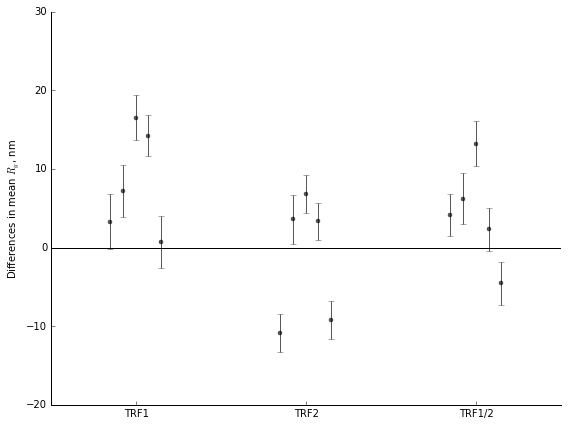

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (8,6))

lineprops = dict(linewidth = 1.0, color = 'k')
pointSpread = 0.15 # For spreading the datapoints in the x-direction
pointSize = 4 # Data point marker size

# Hela L
dataLength = len(stats['Hela L']['Mean']['Diffs']['TRF1'])
ax1.errorbar(1 + linspace(-pointSpread, pointSpread, dataLength),
             stats['Hela L']['Mean']['Diffs']['TRF1'],
             yerr  = stats['Hela L']['Std. Err.']['Diffs']['TRF1'],
             fmt   = 'ok',
             alpha = 0.65,
             markersize = pointSize)

dataLength = len(stats['Hela L']['Mean']['Diffs']['TRF2'])
ax1.errorbar(2 + linspace(-pointSpread, pointSpread, dataLength),
             stats['Hela L']['Mean']['Diffs']['TRF2'],
             yerr  = stats['Hela L']['Std. Err.']['Diffs']['TRF2'],
             fmt   = 'ok',
             alpha = 0.65,
             markersize = pointSize)

dataLength = len(stats['Hela L']['Mean']['Diffs']['TRF1/2'])
ax1.errorbar(3 + linspace(-pointSpread, pointSpread, dataLength),
             stats['Hela L']['Mean']['Diffs']['TRF1/2'],
             yerr  = stats['Hela L']['Std. Err.']['Diffs']['TRF1/2'],
             fmt   = 'ok',
             alpha = 0.65,
             markersize = pointSize)

ax1.plot([0,4], [0,0], 'k', linewidth = 1)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')

ax1.set_xlim((0.5, 3.5))
ax1.set_ylim((-20, 30))
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['TRF1', 'TRF2', 'TRF1/2'])
ax1.set_ylabel(r'Differences in mean $R_g$, nm')
plt.tight_layout()
plt.show()

### Hela S

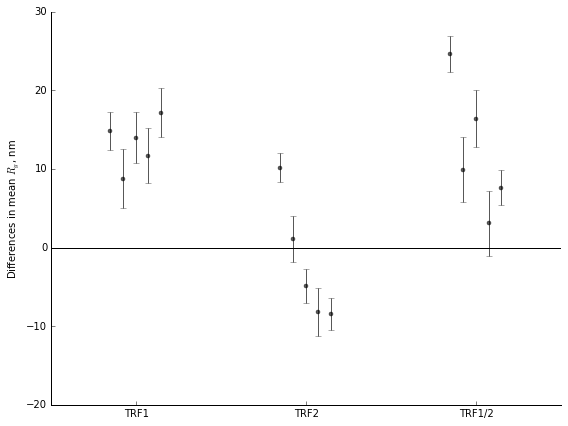

In [7]:
fig, ax2 = plt.subplots(1, 1, figsize = (8,6))

lineprops = dict(linewidth = 1.0, color = 'k')
pointSpread = 0.15 # For spreading the datapoints in the x-direction
pointSize = 4 # Data point marker size

# Hela S
dataLength = len(stats['Hela S']['Mean']['Diffs']['TRF1'])
ax2.errorbar(1 + linspace(-pointSpread, pointSpread, dataLength),
             stats['Hela S']['Mean']['Diffs']['TRF1'],
             yerr  = stats['Hela S']['Std. Err.']['Diffs']['TRF1'],
             fmt   = 'ok',
             alpha = 0.65,
             markersize = pointSize)

dataLength = len(stats['Hela S']['Mean']['Diffs']['TRF2'])
ax2.errorbar(2 + linspace(-pointSpread, pointSpread, dataLength),
             stats['Hela S']['Mean']['Diffs']['TRF2'],
             yerr  = stats['Hela S']['Std. Err.']['Diffs']['TRF2'],
             fmt   = 'ok',
             alpha = 0.65,
             markersize = pointSize)

dataLength = len(stats['Hela S']['Mean']['Diffs']['TRF1/2'])
ax2.errorbar(3 + linspace(-pointSpread, pointSpread, dataLength),
             stats['Hela S']['Mean']['Diffs']['TRF1/2'],
             yerr  = stats['Hela S']['Std. Err.']['Diffs']['TRF1/2'],
             fmt   = 'ok',
             alpha = 0.65,
             markersize = pointSize)

ax2.plot([0,4], [0,0], 'k', linewidth = 1)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')


ax2.set_xlim((0.5, 3.5))
ax2.set_ylim((-20, 30))
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['TRF1', 'TRF2', 'TRF1/2'])
ax2.set_ylabel(r'Differences in mean $R_g$, nm')
plt.tight_layout()
plt.show()

{'05-11-2014 pSuper': 104.48501451769501,
 '08-09-2014 pSuper': 92.761869442628822,
 '09-09-2014 pSuper': 104.86097856561541,
 '17-11-2014 pSuper': 104.17189384266248,
 '21-10-2014 pSuper': 104.52121031237121}

array([ 104.48501452,   92.76186944,  104.86097857,  104.17189384,
        104.52121031])